# Daisy Model, Data of a laboratory setup acting like a hair dryer 

### Description
Laboratory setup acting like a hair dryer. Air is fanned through a tube and heated at the inlet. The air temperature is measured by a thermocouple at the output. The input is the voltage over the heating device (a mesh of resistor wires).

### Sampling
**Number:** 1000

### Inputs
- **u:** voltage of the heating device

### Outputs
- **y:** output air temperature

### References
- Ljung L. *System Identification - Theory for the User.* Prentice Hall, Englewood Cliffs, NJ, 1987.  
- Ljung L. *System Identification Toolbox. For Use with Matlab.* The Mathworks Inc., Mass., U.S.A., 1991.

### Properties
**Columns:**
- Column 1: input u  
- Column 2: output y

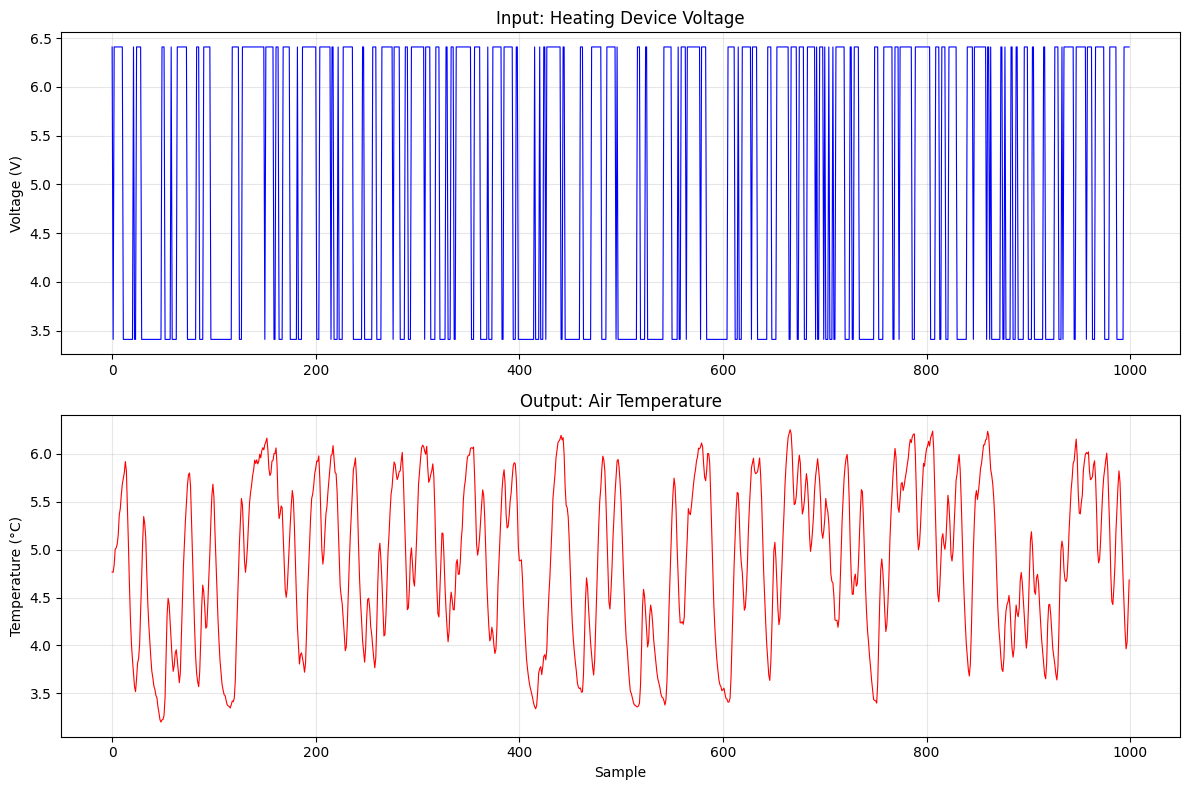

Number of samples: 1000
Voltage range: [3.41, 6.41] V
Temperature range: [3.20, 6.25] °C


In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Cargar los datos
data = np.loadtxt('dryer.dat')
u = data[:, 0]  # voltage input
y = data[:, 1]  # output temperature

# Crear figura con subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Gráfica de la entrada (voltaje)
ax1.plot(u, 'b-', linewidth=0.8)
ax1.set_ylabel('Voltage (V)', fontsize=10)
ax1.set_title('Input: Heating Device Voltage', fontsize=12)
ax1.grid(True, alpha=0.3)

# Gráfica de la salida (temperatura)
ax2.plot(y, 'r-', linewidth=0.8)
ax2.set_xlabel('Sample', fontsize=10)
ax2.set_ylabel('Temperature (°C)', fontsize=10)
ax2.set_title('Output: Air Temperature', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Información básica de los datos
print(f"Number of samples: {len(u)}")
print(f"Voltage range: [{u.min():.2f}, {u.max():.2f}] V")
print(f"Temperature range: [{y.min():.2f}, {y.max():.2f}] °C")


### Definición del modelo

In [ ]:
from scipy import linalg

def arx_221(u, y):
    """
    Modelo ARX(2,2,1)
    
    Modelo: y(t) = a1*y(t-1) + a2*y(t-2) + b1*u(t-1) + b2*u(t-2) + e(t)
    
    Parámetros:
    u : array
        Vector de entrada
    y : array
        Vector de salida
    
    Retorna:
    --------
    dict con:
        - 'a1', 'a2': coeficientes autorregresivos
        - 'b1', 'b2': coeficientes de entrada
        - 'y_pred': predicción del modelo
        - 'error': errores de predicción
        - 'mse': error cuadrático medio
        - 'rmse': raíz del error cuadrático medio
        - 'fit': porcentaje de ajuste
    """
    # Preparar datos
    # ----------------------------------
    N = len(u)
    
    phi = [] # Matriz de regresores: [-y(t-1), -y(t-2), u(t-1), u(t-2)]
    y_vec = [] # Vector de salida
    # -----------------------------------

    # Primera fase 
    # -----------------------------------
    # Empezamos desde t=2 porque necesitamos y(t-1), y(t-2), u(t-1), u(t-2) osea al menos dos entradas anteriores
    for t in range(2, N):
        phi.append([-y[t-1], -y[t-2], u[t-1], u[t-2]])
        y_vec.append(y[t])
    
    # Convertir a arrays de numpy
    phi = np.array(phi)
    y_vec = np.array(y_vec)
    
    # Estimación por mínimos cuadrados: θ = (Φᵀ Φ)⁻¹ Φᵀ y
    theta = linalg.lstsq(phi, y_vec)[0]
    
    # Extraer parámetros
    a1 = -theta[0]  # Coeficiente de y(t-1)
    a2 = -theta[1]  # Coeficiente de y(t-2)
    b1 = theta[2]   # Coeficiente de u(t-1)
    b2 = theta[3]   # Coeficiente de u(t-2)

    # -----------------------------------

    # Fase de estimación continua
    # -----------------------------------
    
    # Simulación del modelo
    y_pred = np.zeros(N)
    y_pred[0] = y[0]  # Condición inicial
    y_pred[1] = y[1]  # Condición inicial
    
    for t in range(2, N):
        # Predicción un paso adelante
        y_pred[t] = a1 * y_pred[t-1] + a2 * y_pred[t-2] + b1 * u[t-1] + b2 * u[t-2]
    
    # Cálculo de errores y métricas
    error = y - y_pred
    mse = np.mean(error[2:]**2)
    rmse = np.sqrt(mse)
    fit = 100 * (1 - np.linalg.norm(y[2:] - y_pred[2:]) / np.linalg.norm(y[2:] - np.mean(y[2:])))
    
    # -----------------------------------

    # Retornar resultados
    return {
        'a1': a1,
        'a2': a2,
        'b1': b1,
        'b2': b2,
        'y_pred': y_pred,
        'error': error,
        'mse': mse,
        'rmse': rmse,
        'fit': fit
    }

### Estimar el modelo ARX(2,2,1) con mis datos

In [7]:
resultado = arx_221(u, y)

print(f"\nEcuación del modelo:")
print(f"y(t) = {resultado['a1']:.6f}*y(t-1) + {resultado['a2']:.6f}*y(t-2) + "
      f"{resultado['b1']:.6f}*u(t-1) + {resultado['b2']:.6f}*u(t-2)")
print()
print(f"Polinomio A(q^-1) = 1 + ({-resultado['a1']:.6f})q^-1 + ({-resultado['a2']:.6f})q^-2")
print(f"Polinomio B(q^-1) = ({resultado['b1']:.6f})q^-1 + ({resultado['b2']:.6f})q^-2")

print(f"\n{'=' * 60}")
print("MÉTRICAS DE AJUSTE")
print("=" * 60)
print(f"MSE:  {resultado['mse']:.6f}")
print(f"RMSE: {resultado['rmse']:.6f}")
print(f"FIT:  {resultado['fit']:.2f}%")
print("=" * 60)


Ecuación del modelo:
y(t) = 1.688955*y(t-1) + -0.738483*y(t-2) + 0.003801*u(t-1) + 0.044176*u(t-2)

Polinomio A(q^-1) = 1 + (-1.688955)q^-1 + (0.738483)q^-2
Polinomio B(q^-1) = (0.003801)q^-1 + (0.044176)q^-2

MÉTRICAS DE AJUSTE
MSE:  0.044297
RMSE: 0.210468
FIT:  74.65%


### Visualización

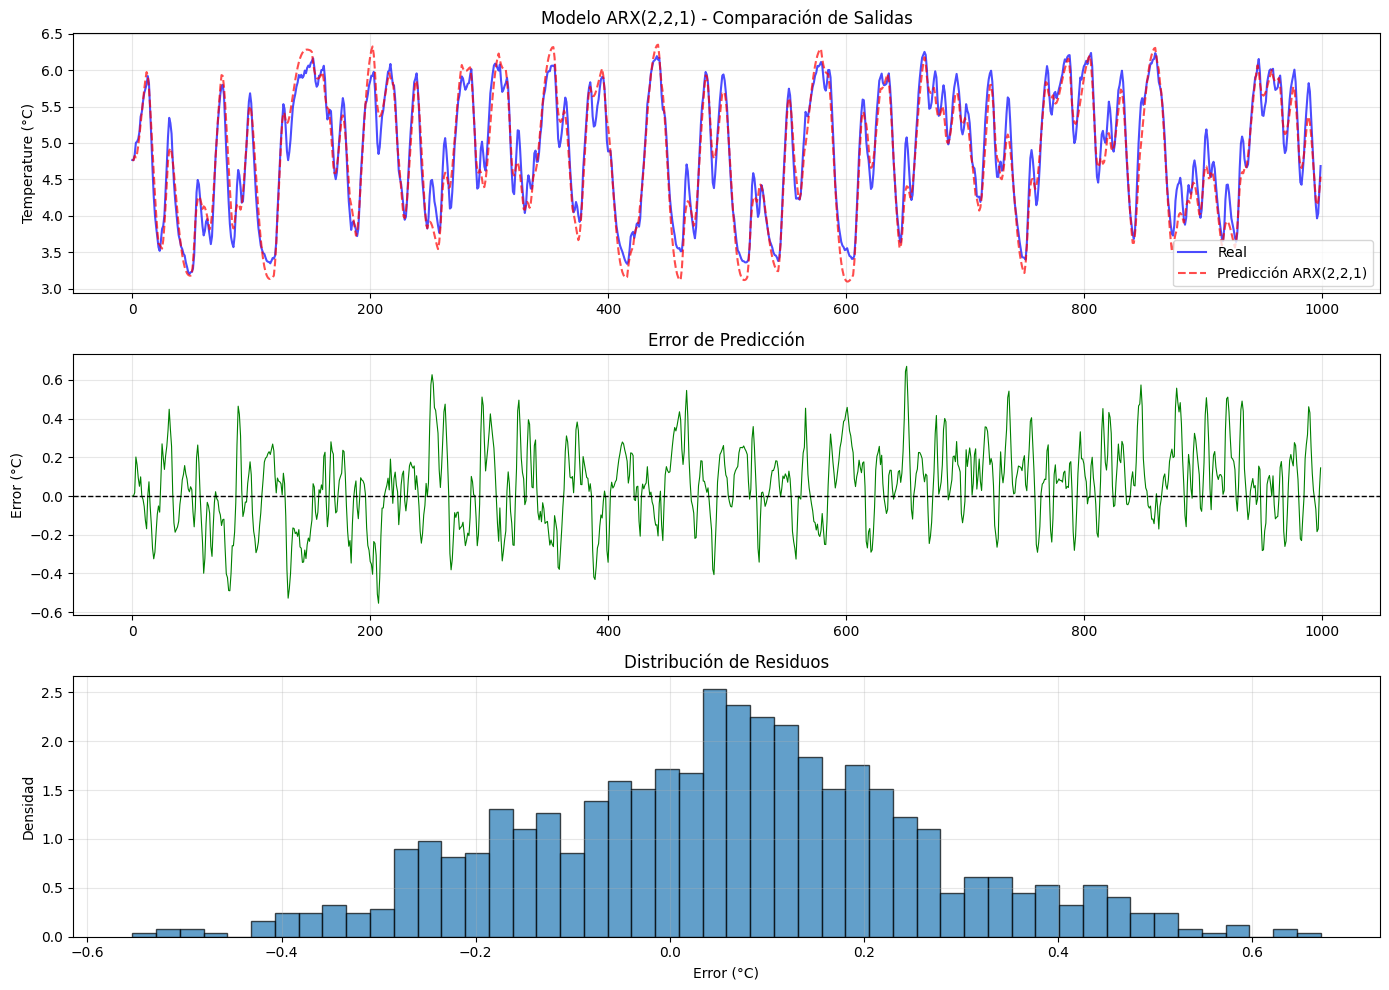

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Gráfica 1: Salida real vs predicha
axes[0].plot(y, 'b-', label='Real', linewidth=1.5, alpha=0.7)
axes[0].plot(resultado['y_pred'], 'r--', label='Predicción ARX(2,2,1)', linewidth=1.5, alpha=0.7)
axes[0].set_ylabel('Temperature (°C)', fontsize=10)
axes[0].set_title('Modelo ARX(2,2,1) - Comparación de Salidas', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Gráfica 2: Error de predicción
axes[1].plot(resultado['error'], 'g-', linewidth=0.8)
axes[1].axhline(y=0, color='k', linestyle='--', linewidth=1)
axes[1].set_ylabel('Error (°C)', fontsize=10)
axes[1].set_title('Error de Predicción', fontsize=12)
axes[1].grid(True, alpha=0.3)

# Gráfica 3: Histograma de residuos
axes[2].hist(resultado['error'][2:], bins=50, density=True, alpha=0.7, edgecolor='black')
axes[2].set_xlabel('Error (°C)', fontsize=10)
axes[2].set_ylabel('Densidad', fontsize=10)
axes[2].set_title('Distribución de Residuos', fontsize=12)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()